In [0]:
#!pip install https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.8.0.dev0-cp36-cp36m-manylinux1_x86_64.whl
!pip install ray
!pip install tensorflow  # or tensorflow-gpu
!pip install ray[rllib]  # also recommended: ray[debug]
!pip uninstall -y pyarrow
!pip install jsonnet
#!pip install -r requirements.txt
# please go to runtime/restart runtime then execute the code!

Uninstalling pyarrow-0.14.1:
  Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 256kB 2.8MB/s 
  Created wheel for jsonnet: filename=jsonnet-0.15.0-cp36-cp36m-linux_x86_64.whl size=3320575 sha256=f42714f5e56e5671c2f03aa4235a91751fc3de997e601647fee2c1455a1a0303
  Stored in directory: /root/.cache/pip/wheels/57/63/2e/da89cfe1ba08550bd7262d5d9c027edc313980c3b85b3b0a38
Successfully built jsonnet


In [0]:
#%%
from google.colab import drive
drive.mount('/content/drive')
#%%

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os

# ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
ROOT_DIR = '/content/drive/My Drive/Colab Notebooks'
RESULT_DIR = f'{ROOT_DIR}/'
# CONFIG_DIR = f'{ROOT_DIR}/configs'
# TENSORBOARD_DIR = f'{ROOT_DIR}/tensorboards'
CONFIG_DIR = TENSORBOARD_DIR = ROOT_DIR = ''
print(CONFIG_DIR)

In [0]:
#%%
import ray
import json
from _jsonnet import evaluate_file
import numpy as np
import os

# ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
# ROOT_DIR = '/content/drive/My Drive/Colab Notebooks'
# RESULT_DIR = f'{ROOT_DIR}/results'
# CONFIG_DIR = f'{ROOT_DIR}/configs'
# TENSORBOARD_DIR = f'{ROOT_DIR}/tensorboards'
# ROOT_DIR = '/content/drive/My Drive/Colab Notebooks'
# RESULT_DIR = f'{ROOT_DIR}/results'
# CONFIG_DIR = f'{ROOT_DIR}/configs'
# TENSORBOARD_DIR = f'{ROOT_DIR}/tensorboards'
ROOT_DIR = '/content/drive/My Drive/Colab Notebooks'
RESULT_DIR = f'{ROOT_DIR}'

"""
:class:`~data_pulling.utilities.registrable.Registrable` is a "mixin" for endowing
any base class with a named registry for its subclasses and a decorator
for registering them. It is adapted from the allennlp codebase:
https://github.com/allenai/allennlp/blob/master/allennlp/common/registrable.py
"""

import logging
from collections import defaultdict
from typing import TypeVar, Type, Dict, List

logger = logging.getLogger(__name__)

T = TypeVar('T')


class Registrable:
    """
    Any class that inherits from ``Registrable`` gains access to a named
    registry for its subclasses. To register them, just decorate them with the
    classmethod ``@BaseClass.register(name)``.
    After which you can call ``BaseClass.list_available()`` to get the keys for
    the registered subclasses, and ``BaseClass.by_name(name)`` to get the
    corresponding subclass.

    Note that the registry stores the subclasses themselves; not class
    instances. In most cases you would then call ``from_params(params)`` on the
    returned subclass.

    You can specify a default by setting ``BaseClass.default_implementation``.
    If it is set, it will be the first element of ``list_available()``.
    Note that if you use this class to implement a new ``Registrable`` abstract
    class, you must ensure that all subclasses of the abstract class are loaded
    when the module is loaded, because the subclasses register themselves in
    their respective files. You can achieve this by having the abstract class
    and all subclasses in the __init__.py of the module in which they reside
    (as this causes any import of either the abstract class or a subclass to
    load all other subclasses and the abstract class).
    """
    _registry: Dict[Type, Dict[str, Type]] = defaultdict(dict)
    default_implementation: str = None

    @classmethod
    def register(cls: Type[T], name: str):
        registry = Registrable._registry[cls]

        def add_subclass_to_registry(subclass: Type[T]):
            # Add to registry, raise an error if key has already been used.
            if name in registry:
                message = "Cannot register %s as %s; name already in use for %s" % (
                    name, cls.__name__, registry[name].__name__)
                raise ConfigurationError(message)
            registry[name] = subclass
            return subclass

        return add_subclass_to_registry

    @classmethod
    def by_name(cls: Type[T], name: str) -> Type[T]:
        logger.debug(f"instantiating registered subclass {name} of {cls}")
        if name not in Registrable._registry[cls]:
            raise ConfigurationError(
                "%s is not a registered name for %s" % (name, cls.__name__))
        return Registrable._registry[cls].get(name)

    @classmethod
    def list_available(cls) -> List[str]:
        """List default first if it exists"""
        keys = list(Registrable._registry[cls].keys())
        default = cls.default_implementation

        if default is None:
            return keys
        elif default not in keys:
            message = "Default implementation %s is not registered" % default
            raise ConfigurationError(message)
        else:
            return [default] + [k for k in keys if k != default]


class ConfigurationError(Exception):
    def __init__(self, message):
        super(ConfigurationError, self).__init__()
        self.message = message

    def __str__(self):
        return repr(self.message)


import numpy as np
from enum import Enum
from typing import NamedTuple, Union


class RLAlgorithm(Enum):
    VI = 'value_iteration'
    PI = 'policy_iteration'
    QLearning = 'q_learning'
    MONTE_CARLO = 'monte_carlo'
    EXPECTED_SARSA = 'expected_sarsa'
    SARSA = 'sarsa'


class TargetUpdate(Enum):
    HARD = 'hard'
    SOFT = 'soft'


class ReplayType(Enum):
    EXPERIENCE_REPLAY = 'ExperienceReplay'
    PRIORITIZED_EXPERIENCE_REPLAY = 'PrioritizedExperienceReplay'


class Transition(NamedTuple):
    # store state, action, reward, next_state, done as Transition tuple
    s0: np.ndarray
    a: int     #a: Union[int, str] 
    r: np.ndarray
    s1: np.ndarray
    done: bool = False



import torch
from collections import defaultdict
from torch.distributions import Categorical
import numpy as np
from gym import Env


def nested_d():
    """for any arbitrary number of levels"""
    return defaultdict(nested_d)


# Thanks Vlad!
def torch_argmax_mask(q: torch.Tensor, dim: int):
    """ Returns a random tie-breaking argmax mask
    Example:
        >>> import torch
        >>> torch.manual_seed(1337)
        >>> q = torch.ones(3, 2)
        >>> torch_argmax_mask(q, 1)
        # tensor([[False,  True],
        #         [ True, False],
        #         [ True, False]])
        >>> torch_argmax_mask(q, 1)
        # tensor([[False,  True],
        #         [False,  True],
        #         [ True, False]])
    """
    rand = torch.rand_like(q)
    if dim == 0:
        mask = rand * (q == q.max(dim)[0])
        mask = mask == mask.max(dim)[0]
        assert int(mask.sum()) == len(q.shape)
    elif dim == 1:
        mask = rand * (q == q.max(dim)[0].unsqueeze(1).expand(q.shape))
        mask = mask == mask.max(dim)[0].unsqueeze(1).expand(q.shape)
        assert int(mask.sum()) == int(q.shape[0])
    else:
        raise NotImplemented("Only vectors and matrices are supported")
    return mask


def get_epsilon_dist(eps: float, env: Env, observation: torch.Tensor,
                     model: torch.nn.Module) -> Categorical:
    """get the probability distributions of the q-value"""
    q = model(observation)
    probs = torch.empty_like(q).fill_(
        eps / (env.action_space.n - 1))
    probs[torch_argmax_mask(q, len(q.shape) - 1)] = 1 - eps
    return Categorical(probs=probs)


def get_epsilon(eps_start: float, eps_final: float, eps_decay: float,
                t: int) -> float:
    """use decay for epsilon exploration"""
    return eps_final + (eps_start - eps_final) * np.exp(-1.0 * t / eps_decay)


def soft_update(value_net: torch.nn.Module, target_net: torch.nn.Module,
                tau: float):
    """update each training step by a hyperparameter adjustment"""
    for t_param, v_param in zip(target_net.parameters(),
                                value_net.parameters()):
        if t_param is v_param:
            continue
        new_param = tau * v_param.data + (1.0 - tau) * t_param.data
        t_param.data.copy_(new_param)


def hard_update(value_net: torch.nn.Module, target_net: torch.nn.Module):
    """update each training step by a full update, based on an update frequency"""
    for t_param, v_param in zip(target_net.parameters(),
                                value_net.parameters()):
        if t_param is v_param:
            continue
        new_param = v_param.data
        t_param.data.copy_(new_param)


import logging
from typing import List
from termcolor import colored


class ProjectLogger:
    def __init__(self,
                 log_file: str = None,
                 level: int = logging.DEBUG,
                 printing: bool = True, attrs: List[str] = None,
                 name: str = 'project_logger',
                 ):
        """ Basic logger that can write to a file on disk or to sterr.
        :param log_file: name of the file to log to
        :param level: logging verbosity level
        :param printing: flag for whether to log to sterr
        """
        root_logger = logging.getLogger(name)
        root_logger.setLevel(level)
        self.printing = printing
        self.attrs = attrs

        # Set up writing to a file
        if log_file:
            file_handler = logging.FileHandler(log_file, mode='a')
            file_formatter = logging.Formatter(
                '%(levelname)s: %(asctime)s %(message)s',
                datefmt='%m/%d/%Y %image:%M:%S %p'
            )
            file_handler.setFormatter(file_formatter)
            root_logger.addHandler(file_handler)

        # Set up printing to stderr
        def check_if_sterr(hdlr: logging.Handler):
            return isinstance(hdlr, logging.StreamHandler) \
                   and not isinstance(hdlr, logging.FileHandler)

        if printing and not list(filter(check_if_sterr, root_logger.handlers)):
            console_handler = logging.StreamHandler()
            console_handler.setFormatter(logging.Formatter("%(message)s"))
            root_logger.addHandler(console_handler)

        self.log = root_logger

    def debug(self, msg, color='grey', attrs: List[str] = None):
        self.log.debug(colored(msg, color, attrs=attrs or self.attrs))

    def info(self, msg, color='green', attrs: List[str] = None):
        self.log.info(colored(msg, color, attrs=attrs or self.attrs))

    def warning(self, msg, color='blue', attrs: List[str] = None):
        self.log.warning(colored(msg, color, attrs=attrs or self.attrs))

    def error(self, msg, color='magenta', attrs: List[str] = None):
        self.log.error(colored(msg, color, attrs=attrs or self.attrs))

    def critical(self, msg, color='red', attrs: List[str] = None):
        self.log.critical(colored(msg, color, attrs=attrs or self.attrs))


import pickle
import os
from typing import Dict
from collections import defaultdict
import plotly
import plotly.graph_objects as go
from torch.utils.tensorboard import SummaryWriter


def plot_episodic_results(idx: int, seed: int, writer: SummaryWriter,
                          episode_result: defaultdict):
    """writes episodic results into tensorboard, called at the end of each
    episode"""
    for k, v in episode_result.items():
        for i in range(idx, idx + len(v)):
            if 'net_params' not in k:
                writer.add_scalar(tag=k, scalar_value=v[i - idx], global_step=i)
            else:
                for tag, value in v[i - idx]:
                    tag_ = f"{tag.replace('.', '/')}/{str(seed)}"
                    writer.add_histogram(tag_, value.data.cpu().numpy(), i)
                    tag_ = f"{tag.replace('.', '/')}/grad/{str(seed)}"
                    writer.add_histogram(tag_, value.grad.data.cpu().numpy(),
                                         i)



import random
from collections import deque
from typing import List, Dict, Tuple
import torch
import numpy as np

class Replay(Registrable):
    @classmethod
    def build(cls, type: str, params: Dict):
        replay = cls.by_name(type)
        return replay.from_params(params)

    @classmethod
    def from_params(cls, params: Dict):
        raise NotImplementedError(
            f'from_params not implemented in {cls.__class__.name}')


# TODO: initial version, not optimized with tree structures used in paper
@Replay.register('ExperienceReplay')
class ExperienceReplay(Replay, Registrable):
    def __init__(self,
                 capacity: int,
                 n_step: int,
                 gamma: float):
        """

        :param capacity: maximum number of transition tuple stored in replay
        :param n_step: n step used for replay
        :param gamma: discount factor when computing td-error
        """
        self.replay_type = self.__class__.__name__
        self.capacity = capacity
        self.memory = deque(maxlen=self.capacity)
        self.n_step = n_step
        if self.n_step > 0:
            self.n_step_memory = deque(maxlen=self.n_step)
            self.gamma = gamma

    @classmethod
    def from_params(cls, params: Dict):
        return cls(**params)

    def push(self, transition: Transition):
        """push Transition into memory for batch sampling and n_step
        computations"""
        if self.n_step > 0:
            self.n_step_memory.append(transition)
            if len(self.n_step_memory) == self.n_step:
                transition = self.generate_n_step_q()
        self.memory.append(transition)

    # TODO: try running with this update
    def generate_n_step_q(self) -> Transition:
        """with s(t), s(t+1), calculate a discounted reward by backtracking
        n_steps prior to t and setting s(t) to s(t-n_steps)"""
        transitions = self.n_step_memory
        reward = 0
        next_observation, done = transitions[-1][-2:]
        for idx, transition in enumerate(transitions):
            reward += (self.gamma ** idx) * transition.r
        # for i in range(len(transitions) - 1):
        #     reward = self.gamma * reward * (1 - transitions[i].done) + \
        #              transitions[i].r
        #     next_observation, done = (transitions[i].s1, transitions[i].done) \
        #         if transitions[i].done else (next_observation, done)
        observation, action = transitions[0][:2]
        return Transition(s0=observation, a=action, r=reward,
                          s1=next_observation, done=done)

    def sample(self, batch_size: int) -> List[Transition]:
        """Uniform sampling with a batch from memory and concatenates the
        dimensions of observations and convert to torch"""
        batch = random.sample(self.memory, batch_size if len(
            self.memory) > batch_size else len(self.memory))
        observation, action, reward, next_observation, done = zip(*batch)
        observation = torch.cat(tuple(torch.FloatTensor(observation)), dim=0)
        action = torch.LongTensor(action)
        reward = torch.FloatTensor(reward)
        next_observation = torch.cat(tuple(torch.FloatTensor(next_observation)),
                                     dim=0)
        done = torch.FloatTensor(done)
        return Transition(s0=observation, a=action, r=reward,
                          s1=next_observation, done=done)

    def __len__(self):
        return len(self.memory)


@Replay.register('PrioritizedExperienceReplay')
class PrioritizedExperienceReplay(ExperienceReplay, Registrable):
    def __init__(self,
                 capacity: int,
                 n_step: int,
                 beta: float,
                 beta_inc: float,
                 gamma: float,
                 non_zero_variant: float):

        """

        :param capacity: maximum number of transition tuple stored in replay
        :param n_step: n step used for replay
        :param gamma: discount rate for calculating td-error
        :param alpha: 0 for no prioritization, 1 for full prioritization
        :param beta:
        :param beta_inc:
        :param non_zero_variant: small constant to ensure non-zero probabilities
        """
        # try with alpha=0.6, beta=0.4, beta_inc=100~network update frequency
        super().__init__(capacity=capacity, n_step=n_step, gamma=gamma)
        self.alpha = 1 - beta
        self.beta = beta
        assert self.alpha + self.beta == 1.0
        self.beta_inc = (1 - beta) / beta_inc
        self.non_zero_variant = non_zero_variant
        self.priorities = np.zeros([self.capacity], dtype=np.float32)
        self.idx = 0
        self.memory = []

    @classmethod
    def from_params(cls, params: Dict):
        return cls(**params)

    def push(self, transition: Transition):
        max_prior = np.max(self.priorities) if self.memory else 1.0

        # n_step computation
        if self.n_step > 0:
            self.n_step_memory.append(transition)
            if len(self.n_step_memory) == self.n_step:
                transition = self.generate_n_step_q()

        # unlike ExperienceReplay which updates based on FIFO
        # update from start of queue
        if len(self.memory) < self.capacity:
            self.memory.append(transition)
        else:
            self.memory[self.idx] = transition
        self.priorities[self.idx] = max_prior
        self.idx += 1
        self.idx = self.idx % self.capacity

    def sample(self, batch_size: int) -> Tuple[List[Transition], np.array]:
        """use absolute td-error to favor model to optimize"""
        if len(self.memory) < self.capacity:
            probs = self.priorities[:len(self.memory)]
        else:
            probs = self.priorities
        # probs = abs(td-error), use probabilities
        probs = (probs ** self.alpha) / np.sum(probs ** self.alpha)
        self.indices = np.random.choice(len(self.memory), batch_size, p=probs)
        if self.beta < 1:
            self.beta += self.beta_inc

        # samples a batch from memory and concatenates the dimensions of
        # observations and convert to torch
        batch = [self.memory[idx] for idx in self.indices]
        observation, action, reward, next_observation, done = zip(*batch)
        observation = torch.cat(tuple(torch.FloatTensor(observation)), dim=0)
        action = torch.LongTensor(action)
        reward = torch.FloatTensor(reward)
        next_observation = torch.cat(tuple(torch.FloatTensor(next_observation)),
                                     dim=0)
        done = torch.FloatTensor(done)

        # need weights to compute loss
        weights = (len(self.memory) * probs[self.indices]) ** -self.beta
        weights = np.array(weights / np.max(weights), dtype=np.float32)
        return Transition(s0=observation, a=action, r=reward,
                          s1=next_observation, done=done), weights

    def update_priorities(self, losses: np.array):
        """update absolute td-error to compute probabilities"""
        for idx, priority in zip(self.indices, losses):
            self.priorities[idx] = priority



from typing import Dict, Generator, List, Tuple
import torch
import torch.nn as nn


class TorchModel(nn.Module, Registrable):
    @classmethod
    def build(cls, type: str, params: Dict):
        model = cls.by_name(type)
        return model.from_params(params)

    @classmethod
    def from_params(cls, params: Dict):
        return cls(**params)

    def forward(self, *input):
        raise NotImplementedError()

    def to_device(self, device):
        self.to(device)
        self.device = device


@TorchModel.register('LinearFCBody')
class LinearFCBody(TorchModel):
    def __init__(self,
                 seed: int,
                 state_dim: int,
                 action_dim: int,
                 hidden_units: List = [64, 64],
                 gate: nn.ReLU = nn.ReLU):
        super(LinearFCBody, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.state_dim = state_dim
        self.action_dim = action_dim
        hidden_unit_1, hidden_unit_2 = hidden_units[0], hidden_units[1]
        self.fc1 = nn.Sequential(
            nn.Linear(self.state_dim, hidden_unit_1),
            # nn.BatchNorm1d(hidden_size1),
            gate()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(hidden_unit_1, hidden_unit_2),
            # nn.BatchNorm1d(hidden_size2),
            gate()
        )
        self.fc3 = nn.Linear(hidden_unit_2, self.action_dim)

    @classmethod
    def from_params(cls, params: Dict):
        return cls(**params)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x


@TorchModel.register('BasicRNN')
class BasicRNN(TorchModel):
    def __init__(self,
                 seed: int,
                 input_dim: int,
                 hidden_dim: int,
                 num_layers: int,
                 output_dim: int,
                 dropout: float = 0,
                 bidirectional: bool = False):
        super().__init__()
        self.seed = torch.manual_seed(seed)
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.num_directions = 2 if bidirectional else 1
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True,
                            bidirectional=bidirectional)
        self.fc = nn.Linear(hidden_dim * self.num_directions, output_dim)

    @classmethod
    def from_params(cls, params: Dict):
        return cls(**params)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers * self.num_directions,
                         x.size(0), self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers * self.num_directions,
                         x.size(0), self.hidden_dim).to(self.device)

        # Forward propagate LSTM
        # out: tensor of shape (batch_size, seq_length, hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


@TorchModel.register('Inception')
class Inception(TorchModel):
    def __init__(self,
                 in_channels: int,
                 gate: nn.ReLU):
        super().__init__()
        out_channels = 32
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1)),
            # gate(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 1)), )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1)),
            # gate(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(5, 1)), )
        self.conv3 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3, 1)),
            # gate(),
            nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1)), )

    @classmethod
    def from_params(cls, params: Dict):
        return cls(**params)

    def forward(self, x):
        # (batch_size, out_channels, timesteps, features),
        # timesteps=timesteps-kernel+1
        conv1 = self.conv1(x)
        conv2 = self.conv2(x)
        conv3 = self.conv3(x)
        outputs = [conv1, conv2, conv3]
        return torch.cat(outputs, 2)  # concatenate by timesteps



from gym import Env
from typing import Dict


class Agent(Registrable):
    @classmethod
    def build(cls, type: str, env: Env, params: Dict):
        agent = cls.by_name(type)
        return agent.from_params(env, params)

    @classmethod
    def from_params(cls, env: Env, params: Dict):
        raise NotImplementedError(
            f'from_params not implemented in {cls.__name__}')


import time
import numpy as np
from typing import Dict, Generator, Tuple
from gym import Env
import torch.optim as optim
import torch.nn as nn
import torch
# import torchviz


@Agent.register('DeepTDAgent')
class DeepTDAgent(Agent, Registrable):
    def __init__(self,
                 env: Env,
                 agent_cfg: Dict):
        """

        :param env: gym environment used for Experiment
        :param agent_cfg: config file for given agent
        """
        super().__init__()
        self.env = env
        self.epochs, self.total_steps = 0, 0
        self.episodic_result = dict()
        self.episodic_result['Training/Q-Loss'] = []
        self.episodic_result['Training/Mean-Q-Value-Action'] = []
        self.episodic_result['Training/Mean-Q-Value-Opposite-Action'] = []
        self.episodic_result['value_net_params'] = []

        # specs for RL agent
        self.eps = agent_cfg['eps']
        if agent_cfg['use_eps_decay']:
            self.use_eps_decay = agent_cfg['use_eps_decay']
            self.eps_decay = agent_cfg['eps_decay']
            self.eps_min = agent_cfg['eps_min']
        self.gamma = agent_cfg['gamma']
        self.update_type = agent_cfg['update_type']
        if self.update_type == TargetUpdate.SOFT.value:
            self.tau = agent_cfg['tau']
        self.update_freq = agent_cfg['update_freq']
        self.warm_up_freq = agent_cfg['warm_up_freq']
        self.use_grad_clipping = agent_cfg['use_grad_clipping']
        self.grad_clipping = agent_cfg['grad_clipping']
        self.lr = agent_cfg['lr']
        self.batch_size = agent_cfg['batch_size']
        self.seed = agent_cfg['seed']
        self.params = vars(self).copy()

        # details experience replay
        self.replay_buffer = Replay.build(
            type=agent_cfg['experience_replay']['type'],
            params=agent_cfg['experience_replay']['params'])

        # details for the NN model
        agent_cfg['model']['seed'] = self.seed
        use_cuda = agent_cfg['use_gpu'] and torch.cuda.is_available()
        self.device = torch.device("cuda" if use_cuda else "cpu")
        self.value_net = TorchModel.build(type=agent_cfg['model']['type'],
                                          params=agent_cfg['model']['params'])
        self.target_net = TorchModel.build(type=agent_cfg['model']['type'],
                                           params=agent_cfg['model']['params'])
        self.value_net.to_device(self.device)
        self.target_net.to_device(self.device)
        self.target_net.load_state_dict(self.value_net.state_dict())
        self.target_net.eval()
        self.optimizer = optim.Adam(self.value_net.parameters(), self.lr)

        # Huber loss acts like the mean squared error when the error is small,
        # but like the mean absolute error when the error is large
        # this makes it more robust to outliers when the estimates of Q
        # are very noisy. It is calculated over a batch of transitions
        # sampled from the replay memory:
        self.loss_func = nn.SmoothL1Loss()

    @classmethod
    def from_params(cls, env: Env, params: Dict):
        return cls(env, **params)

    @torch.no_grad()
    def get_action(self, observation) -> int:
        """either take greedy action or explore with epsilon rate"""
        if np.random.random() < self.eps:
            # return self.env.action_space.sample()
            return np.random.randint(self.env.action_space.n)
        else:
            state = torch.FloatTensor(observation).to(self.device)
            return self.value_net(state).max(1)[1].data[0].item()
        # observation = torch.FloatTensor(observation).to(self.device)
        # dist = get_epsilon_dist(eps=self.eps, env=self.env,
        #                         model=self.value_net, observation=observation)
        # return dist.sample().item()

    def train(self):
        raise NotImplementedError('DeepTD Agent requires a train() method')

    def training_update(self):
        """backprop loss, target network, epsilon, and result updates"""
        self.epochs += 1
        self.train()

        # hard update
        if self.update_type == TargetUpdate.HARD.value:
            if self.epochs != 0 and self.update_freq % self.epochs == 0:
                self.target_net.load_state_dict(
                    self.value_net.state_dict())
        elif self.update_type == TargetUpdate.SOFT.value:
            soft_update(value_net=self.value_net, target_net=self.target_net,
                        tau=self.tau)

        if self.use_eps_decay:
            # self.eps = get_epsilon(eps_start=self.eps, eps_final=self.eps_min,
            #                        eps_decay=self.eps_decay, t=1)
            if self.eps >= self.eps_min:
                self.eps *= self.eps_decay

        # save episodic results
        self.episodic_result['Training/Q-Loss'].append(
            self.loss.detach().cpu().numpy())
        self.episodic_result['Training/Mean-Q-Value-Action'].append(
            np.mean(self.q.detach().cpu().numpy()))
        self.episodic_result[
            'Training/Mean-Q-Value-Opposite-Action'].append(
            np.mean(self.q_.detach().cpu().numpy()))
        # self.episodic_result['value_net_params'].append(
        #     self.value_net.named_parameters())

    def interact(self, num_steps: int) -> Generator:
        """use agent to interact with environment by making actions based on
        optimal policy to obtain cumulative rewards"""
        cr, t = 0, 0
        done = False
        start = time.time()
        observation = self.env.reset()
        observation = np.expand_dims(observation, 0)
        action = self.get_action(observation=observation)

        while not done and t < num_steps:
            self.total_steps += 1
            next_observation, reward, done, info = self.env.step(action)
            next_observation = np.expand_dims(next_observation, 0)
            cr += reward

            # store into experience replay buffer and sample batch of
            # transitions to estimate the q-values and train on losses
            transition = Transition(s0=observation, a=action, r=reward,
                                    s1=next_observation, done=done)
            self.replay_buffer.push(transition)

            # train policy network and update target network
            # update epsilon decay, more starting exploration
            if self.total_steps >= self.warm_up_freq:
                self.training_update()

            observation = next_observation
            action = self.get_action(observation=observation)
            t += 1

        # TODO: pause training and use eval with generator, need to add eval!
        yield {
            'cum_reward': cr,
            'time_to_solve': t,
            'mean_q_loss': np.mean(self.episodic_result['Training/Q-Loss'][-t:]),
            'mean_action_q_value': np.mean(self.episodic_result[
                                       'Training/Mean-Q-Value-Action'][-t:]),
            'mean_opposite_action_q_value': np.mean(self.episodic_result[
                                       'Training/Mean-Q-Value-Opposite-Action'][
                                   -t:]),
            'episode_time': time.time() - start,
        }


@Agent.register('DQNAgent')
class DQNAgent(DeepTDAgent, Registrable):
    def __init__(self, env: Env, agent_cfg: Dict):
        super().__init__(env, agent_cfg)
        self.use_double = agent_cfg['use_double']

    @classmethod
    def from_params(cls, env: Env, params: Dict):
        return cls(env, params)

    def train(self):
        # handle different replay types
        if self.replay_buffer.replay_type == ReplayType.EXPERIENCE_REPLAY.value:
            batch = self.replay_buffer.sample(batch_size=self.batch_size)
        elif self.replay_buffer.replay_type == \
                ReplayType.PRIORITIZED_EXPERIENCE_REPLAY.value:
            batch, weights = self.replay_buffer.sample(
                batch_size=self.batch_size)

        # handle different DQN
        if self.use_double:
            next_q = self.target_net(batch.s1).max(1)[0]
        else:
            next_q_actions = torch.max(self.value_net(batch.s1), dim=1)[1]
            next_q = self.target_net(batch.s1).gather(1,
                                                      next_q_actions.unsqueeze(
                                                          1)).squeeze(1)

        # expected Q and Q using value net
        q_values = self.value_net(batch.s0)
        self.q = q_values.gather(1, batch.a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            self.q_ = q_values.gather(1, 1 - batch.a.unsqueeze(1)).squeeze(1)
            expected_q = batch.r + self.gamma * (1 - batch.done) * next_q
        if self.replay_buffer.replay_type == ReplayType.EXPERIENCE_REPLAY.value:
            self.loss = self.loss_func(expected_q, self.q)
        elif self.replay_buffer.replay_type == ReplayType. \
                PRIORITIZED_EXPERIENCE_REPLAY.value:
            self.loss = self.loss_func(expected_q, self.q) * torch.FloatTensor(
                weights)
        # torchviz.make_dot(self.loss).render('loss')
        self.loss = self.loss.mean()
        self.optimizer.zero_grad()
        self.loss.backward()

        # gradient clipping to avoid loss divergence based on DeepMind's DQN in
        # 2015, where the author clipped the gradient within [-1, 1]
        if self.use_grad_clipping:
            nn.utils.clip_grad_norm_(self.value_net.parameters(),
                                     self.grad_clipping)

        # update replay buffer..
        if self.replay_buffer.replay_type == ReplayType. \
                PRIORITIZED_EXPERIENCE_REPLAY.value:
            # less memory used
            with torch.no_grad():
                abs_td_error = torch.abs(expected_q - self.q).cpu().numpy() + \
                               self.replay_buffer.non_zero_variant
            self.replay_buffer.update_priorities(losses=abs_td_error)
        self.optimizer.step()


@Agent.register('DeepSarsaAgent')
class DeepSarsaAgent(DeepTDAgent, Registrable):
    def __init__(self, env: Env, agent_cfg: Dict):
        super().__init__(env, agent_cfg)

    @classmethod
    def from_params(cls, env: Env, params: Dict):
        return cls(env, params)

    def train(self):
        # handle different replay types
        if self.replay_buffer.replay_type == ReplayType.EXPERIENCE_REPLAY.value:
            batch = self.replay_buffer.sample(batch_size=self.batch_size)
        elif self.replay_buffer.replay_type == \
                ReplayType.PRIORITIZED_EXPERIENCE_REPLAY.value:
            batch, weights = self.replay_buffer.sample(
                batch_size=self.batch_size)

        next_q = self.target_net(batch.s1).gather(1,
                                                  batch.a.unsqueeze(1)).squeeze(
            1)

        q_values = self.value_net(batch.s0)
        self.q = q_values.gather(1, batch.a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            self.q_ = q_values.gather(1, 1 - batch.a.unsqueeze(1)).squeeze(1)
            expected_q = batch.r + self.gamma * (1 - batch.done) * next_q
        if self.replay_buffer.replay_type == ReplayType.EXPERIENCE_REPLAY.value:
            self.loss = self.loss_func(expected_q, self.q)
        elif self.replay_buffer.replay_type == ReplayType. \
                PRIORITIZED_EXPERIENCE_REPLAY.value:
            self.loss = self.loss_func(expected_q, self.q) * torch.FloatTensor(
                weights)
        # torchviz.make_dot(self.loss).render('loss')
        self.loss = self.loss.mean()
        self.optimizer.zero_grad()
        self.loss.backward()

        # gradient clipping to avoid loss divergence based on DeepMind's DQN in
        # 2015, where the author clipped the gradient within [-1, 1]
        if self.use_grad_clipping:
            nn.utils.clip_grad_norm_(self.value_net.parameters(),
                                     self.grad_clipping)

        # update replay buffer..
        if self.replay_buffer.replay_type == ReplayType. \
                PRIORITIZED_EXPERIENCE_REPLAY.value:
            # less memory used
            with torch.no_grad():
                abs_td_error = torch.abs(expected_q - self.q).cpu().numpy() + \
                               self.replay_buffer.non_zero_variant
            self.replay_buffer.update_priorities(losses=abs_td_error)
        self.optimizer.step()


@Agent.register('DeepExpectedSarsaAgent')
class DeepExpectedSarsaAgent(DeepTDAgent, Registrable):
    def __init__(self, env: Env, agent_cfg: Dict):
        super().__init__(env, agent_cfg)

    @classmethod
    def from_params(cls, env: Env, params: Dict):
        return cls(env, params)

    def train(self):
        # handle different replay types
        if self.replay_buffer.replay_type == ReplayType.EXPERIENCE_REPLAY.value:
            batch = self.replay_buffer.sample(batch_size=self.batch_size)
        elif self.replay_buffer.replay_type == \
                ReplayType.PRIORITIZED_EXPERIENCE_REPLAY.value:
            batch, weights = self.replay_buffer.sample(
                batch_size=self.batch_size)
        prob_dist = get_epsilon_dist(eps=self.eps, env=self.env,
                                     model=self.value_net, observation=batch.s1)
        next_q = torch.sum(self.target_net(batch.s1) * prob_dist.probs,
                           axis=1)

        # expected Q and Q using value net
        q_values = self.value_net(batch.s0)
        self.q = q_values.gather(1, batch.a.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            self.q_ = q_values.gather(1, 1 - batch.a.unsqueeze(1)).squeeze(1)
            expected_q = batch.r + self.gamma * (1 - batch.done) * next_q
        if self.replay_buffer.replay_type == ReplayType.EXPERIENCE_REPLAY.value:
            self.loss = self.loss_func(expected_q, self.q)
        elif self.replay_buffer.replay_type == ReplayType. \
                PRIORITIZED_EXPERIENCE_REPLAY.value:
            self.loss = self.loss_func(expected_q, self.q) * torch.FloatTensor(
                weights)
        # torchviz.make_dot(self.loss).render('loss')
        self.loss = self.loss.mean()
        self.optimizer.zero_grad()
        self.loss.backward()

        # gradient clipping to avoid loss divergence based on DeepMind's DQN in
        # 2015, where the author clipped the gradient within [-1, 1]
        if self.use_grad_clipping:
            nn.utils.clip_grad_norm_(self.value_net.parameters(),
                                     self.grad_clipping)

        # update replay buffer..
        if self.replay_buffer.replay_type == ReplayType. \
                PRIORITIZED_EXPERIENCE_REPLAY.value:
            # less memory used
            with torch.no_grad():
                abs_td_error = torch.abs(expected_q - self.q).cpu().numpy() + \
                               self.replay_buffer.non_zero_variant
            self.replay_buffer.update_priorities(losses=abs_td_error)
        self.optimizer.step()


from typing import Dict, List
from collections import defaultdict
from datetime import datetime

class Experiment(Registrable):
    def __init__(self,
                 logger: ProjectLogger,
                 env_names: List,
                 agents: List,
                 seeds: List,
                 experiment_cfg: dict,
                 agent_cfg: dict,
                 *args, **kwargs):
        self.logger = logger
        self.env_names = env_names
        self.agents = agents
        self.seeds = seeds
        self.experiment_cfg = experiment_cfg
        self.agent_cfg = agent_cfg
        self.experiment_cfg['date'] = datetime.today().strftime('%Y-%m-%d')

    @classmethod
    def build(cls, type: str, logger: ProjectLogger, params: Dict):
        experiment = cls.by_name(type)
        return experiment.from_params(logger, params)

    @classmethod
    def from_params(cls, logger: ProjectLogger, params: Dict):
        return cls(logger, **params)

    def generate_metrics(self, results: List) -> defaultdict:
        """generate whatever metrics needed for the experiment"""
        raise NotImplementedError('Experiment must generate metrics!')


import ray
import gym
import numpy as np
import pickle
from collections import defaultdict, deque
from typing import Dict, List, Tuple

from torch.utils.tensorboard import SummaryWriter


@ray.remote
def inner_run(agent_cfg: dict, experiment_cfg: dict,
                env_name: str, seed: int = 1, agent_name: str = 'sarsa'):

    # seed and result initialization
    np.random.seed(seed)
    mean_q_loss = np.zeros((len(experiment_cfg['lrs']),
                              experiment_cfg['runs'],
                              experiment_cfg['episodes']))
    cum_reward = np.zeros((len(experiment_cfg['lrs']),
                            experiment_cfg['runs'],
                            experiment_cfg['episodes']))
    time_to_solve = np.ones((len(experiment_cfg['lrs']),
                              experiment_cfg['runs'],
                              experiment_cfg['episodes'])) * experiment_cfg[
                        'steps']
    env = gym.make(env_name)

    # O(lrs * runs * episodes * max(test_rng * steps, steps))
    for i_lr in range(len(experiment_cfg['lrs'])):
        # create agent, set the learning rate, tensorboard path..
        agent_config = agent_cfg[agent_name]
        agent_config['lr'] = experiment_cfg['lrs'][i_lr]
        agent_config['seed'] = seed
        agent = Agent.build(type=agent_name, env=env, params=agent_config)

        # go through runs, in order to further average, and episodes
        for r in range(experiment_cfg['runs']):
            for i_episode in range(experiment_cfg['episodes']):
                generator_obj = agent.interact(
                    num_steps=experiment_cfg['steps'])
                episode_result = next(generator_obj)
                cum_reward[i_lr, r, i_episode] = episode_result[
                    'cum_reward']
                time_to_solve[i_lr, r, i_episode] = episode_result[
                    'time_to_solve']
                mean_q_loss[i_lr, r, i_episode] = episode_result[
                    'mean_q_loss']
                if episode_result['cum_reward'] >= 100:
                    msg = f"lr {agent_config['lr']} | run {r} | " \
                        f"episode {i_episode} | eps {agent.eps} "
                    for k, v in episode_result.items():
                        msg += f"| {k} {v} "
                    print(msg)
    env.close()

    # generates learning rates * episodes
    cum_reward = np.mean(cum_reward, axis=1)
    time_to_solve = np.mean(time_to_solve, axis=1)
    return cum_reward, time_to_solve, mean_q_loss


@Experiment.register('DeepTDExperiment')
class DeepTDExperiment(Experiment):
    def __init__(self,
                 logger: ProjectLogger,
                 *args, **kwargs):
        super().__init__(logger=logger, *args, **kwargs)
        self.replay_buffer_capacities = self.experiment_cfg[
            'replay_buffer_capacities']
        self.lrs = self.experiment_cfg['lrs']

    @classmethod
    def from_params(cls, logger: ProjectLogger, params: Dict):
        return cls(logger, **params)

    def run(self):
        """for each gym environment and RL agentrithms, test different replay
        buffer capaciity over multiple seeds"""
        output = defaultdict(nested_d)
        for env_name in self.env_names:
            for agent in self.agents:
                for capacity in self.replay_buffer_capacities:
                    self.agent_cfg[agent]['experience_replay']['params'][
                        'capacity'] = capacity
                    results = [inner_run.remote(
                        agent_cfg=self.agent_cfg,
                        experiment_cfg=self.experiment_cfg,
                        env_name=env_name, seed=seed, agent_name=agent) for seed
                        in self.seeds]
                    results = ray.get(results)
                    output = self.generate_metrics(env_name=env_name,
                                                   agent=agent,
                                                   capacity=capacity,
                                                   results=results,
                                                   output=output)
                    with open(self.experiment_cfg['experiment_path'],
                              'wb') as file:
                        pickle.dump(output, file)
                self.logger.info(
                    f'Finished running experiments for {env_name} | {agent}')
        return output

    def generate_metrics(self, env_name: str, agent: str, capacity: int,
                         results: List, output: defaultdict):
        """generate whatever metrics needed for the experiment"""
        # results over the seeds
        for idx, lr in enumerate(self.experiment_cfg['lrs']):
            output[env_name][agent][capacity]['mean_q_loss'][lr] = np.mean(
                [results[i][2] for i in range(len(results))], axis=0)[idx]
            output[env_name][agent][capacity]['mean_cum_rewards'][lr] = np.mean(
                [results[i][0] for i in range(len(results))], axis=0)[idx]
            output[env_name][agent][capacity]['std_cum_rewards'][lr] = np.std(
                [results[i][0] for i in range(len(results))], axis=0)[idx]
            output[env_name][agent][capacity]['upper_std_cum_rewards'][lr] = \
                output[env_name][agent][capacity]['mean_cum_rewards'][lr] + \
                output[env_name][agent][capacity]['std_cum_rewards'][lr]
            output[env_name][agent][capacity]['lower_std_cum_rewards'][lr] = \
                output[env_name][agent][capacity]['mean_cum_rewards'][lr] - \
                output[env_name][agent][capacity]['std_cum_rewards'][lr]
            output[env_name][agent][capacity]['max_cum_rewards'][lr] = np.max(
                [results[i][0] for i in range(len(results))], axis=0)[idx]
            output[env_name][agent][capacity]['mean_timesteps'][lr] = np.mean(
                [results[i][1] for i in range(len(results))], axis=0)[idx]
            output[env_name][agent][capacity]['min_timesteps'][lr] = np.min(
                [results[i][1] for i in range(len(results))], axis=0)[idx]
            output[env_name][agent][capacity]['max_timesteps'][lr] = np.max(
                [results[i][1] for i in range(len(results))], axis=0)[idx]
        return output




if __name__ == "__main__":
    # logger
    import time
    logger = ProjectLogger(level=10)
    start = time.time()
    logger.info(f'Experiment starting time: {start}')

    # load initial configs for params
    cfg = evaluate_file(f'n_step_td_config.jsonnet')
    logger.info(f'Using the following config: \n{cfg}')
    cfg = json.loads(cfg)
    
    ray.init(
        #local_mode=True,
        ignore_reinit_error=True,
    )

    # specs for the experiment & agent
    experiment_cfg, agent_cfg = cfg['experiment_cfg'], cfg['agent_cfg']
    experiment_path = f"{RESULT_DIR}/{cfg['experiment_name']}_experiments.pickle"
    hyperparams_path = f"{cfg['experiment_name']}_experiments_hyperparameters.pickle"
    tensorboard_path = f"{cfg['experiment_name']}/trainer"
    experiment_cfg['experiment_path'] = experiment_path
    experiment_cfg['hyperparams_path'] = hyperparams_path
    experiment_cfg['tensorboard_path'] = tensorboard_path
    seeds = np.random.choice(99999, 10, replace=False)
    # seeds = [1337]
    agents = cfg['agents']
    env_names = cfg['env_names']
    params = {'env_names': env_names, 'agents': agents, 'seeds': seeds,
              'experiment_cfg': experiment_cfg, 'agent_cfg': agent_cfg}

    experiment = Experiment.build(type=cfg['experiment_name'], logger=logger,
                                  params=params)

    # run dp experiments
    output = experiment.run()
    logger.info(f'Finished running experiments at {time.time() - start}')
    

Experiment starting time: 1583090114.6767833
Using the following config: 
{
   "agent_cfg": {
      "DQNAgent": {
         "batch_size": 32,
         "eps": 1,
         "eps_decay": 0.999,
         "eps_min": 0.10000000000000001,
         "experience_replay": {
            "params": {
               "beta": 0.40000000000000002,
               "beta_inc": 10000,
               "capacity": 500,
               "gamma": 0.90000000000000002,
               "n_step": 4,
               "non_zero_variant": 9.9999999999999995e-07
            },
            "type": "PrioritizedExperienceReplay"
         },
         "gamma": 0.90000000000000002,
         "grad_clipping": 1,
         "lr": 0.01,
         "model": {
            "params": {
               "action_dim": 2,
               "hidden_units": [
                  64,
                  64
               ],
               "seed": 1337,
               "state_dim": 4
            },
            "type": "LinearFCBody"
         },
         "tau": 

(pid=903) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=903)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=903) /usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
(pid=903)   out=out, **kwargs)
(pid=903) /usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
(pid=903)   ret = ret.dtype.type(ret / rcount)
(pid=902) /usr/local/lib/python3.6/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
(pid=902)   warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
(pid=902) /usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
(pid=902)   out=out, **kwargs)
(pid=902) /usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning:

Finished running experiments for CartPole-v0 | DQNAgent


(pid=903) lr 0.001 | run 0 | episode 1 | eps 1 | cum_reward 106.0 | time_to_solve 106 | mean_q_loss nan | mean_action_q_value nan | mean_opposite_action_q_value nan | episode_time 0.010549068450927734 
(pid=902) lr 0.001 | run 0 | episode 80 | eps 0.16058777361462884 | cum_reward 200.0 | time_to_solve 200 | mean_q_loss 1.7586132287979126 | mean_action_q_value 22.905742645263672 | mean_opposite_action_q_value 22.775346755981445 | episode_time 1.1471223831176758 
(pid=903) lr 0.001 | run 0 | episode 77 | eps 0.11990437759912596 | cum_reward 197.0 | time_to_solve 197 | mean_q_loss 1.4696757793426514 | mean_action_q_value 23.201770782470703 | mean_opposite_action_q_value 23.32611083984375 | episode_time 1.122976303100586 
(pid=903) lr 0.001 | run 0 | episode 78 | eps 0.09994334856146549 | cum_reward 200.0 | time_to_solve 200 | mean_q_loss 1.011411428451538 | mean_action_q_value 23.775537490844727 | mean_opposite_action_q_value 23.722177505493164 | episode_time 1.1652252674102783 
(pid=903)

Finished running experiments for CartPole-v0 | DeepExpectedSarsaAgent


Streaming output truncated to the last 5000 lines.
(pid=903) lr 0.001 | run 0 | episode 168 | eps 0.09994334856146549 | cum_reward 200.0 | time_to_solve 200 | mean_q_loss 0.44402581453323364 | mean_action_q_value 25.798171997070312 | mean_opposite_action_q_value 25.61810874938965 | episode_time 0.9513139724731445 
(pid=902) lr 0.0025 | run 0 | episode 88 | eps 0.09994334856146549 | cum_reward 200.0 | time_to_solve 200 | mean_q_loss 0.7321667671203613 | mean_action_q_value 26.559288024902344 | mean_opposite_action_q_value 26.546768188476562 | episode_time 0.9574334621429443 
(pid=903) lr 0.001 | run 0 | episode 169 | eps 0.09994334856146549 | cum_reward 200.0 | time_to_solve 200 | mean_q_loss 0.4250164031982422 | mean_action_q_value 25.736066818237305 | mean_opposite_action_q_value 25.38147735595703 | episode_time 0.9309699535369873 
(pid=903) lr 0.001 | run 0 | episode 170 | eps 0.09994334856146549 | cum_reward 118.0 | time_to_solve 118 | mean_q_loss 0.4044322669506073 | mean_action_q_

Finished running experiments for CartPole-v0 | DeepSarsaAgent
Finished running experiments at 14703.062063217163


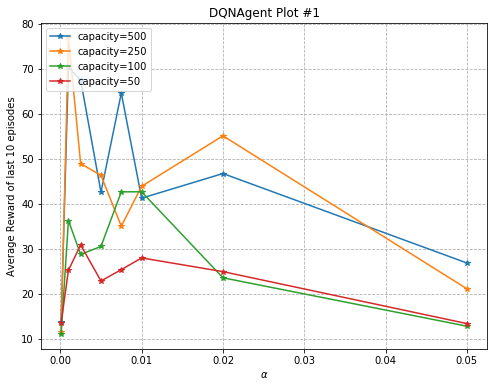

<Figure size 432x288 with 0 Axes>

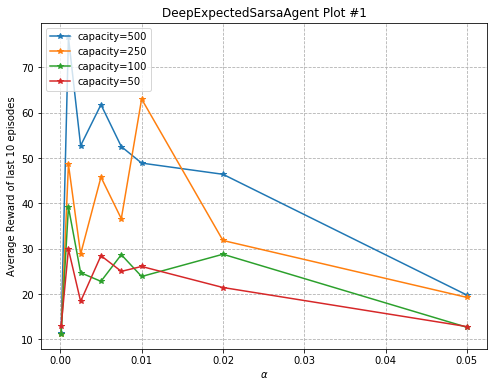

<Figure size 432x288 with 0 Axes>

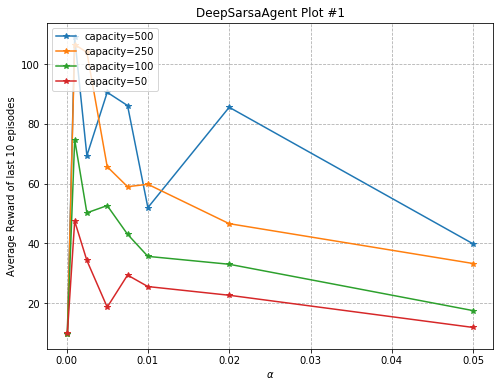

defaultdict(<function nested_d at 0x7f4cf5f27f28>, {'DQNAgent': [50, 0.0001], 'DeepExpectedSarsaAgent': [500, 0.0001], 'DeepSarsaAgent': [100, 0.0001]})


<Figure size 432x288 with 0 Axes>

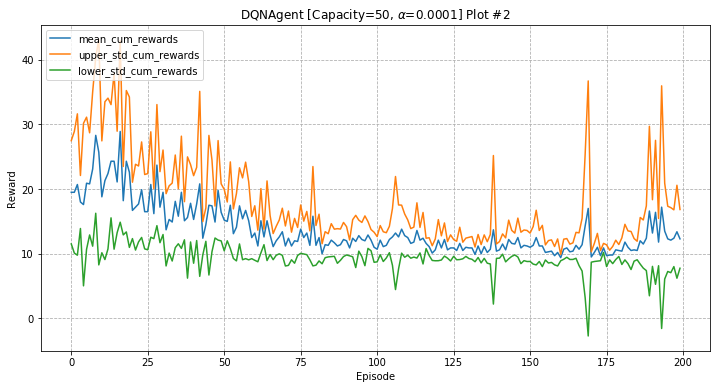

<Figure size 432x288 with 0 Axes>

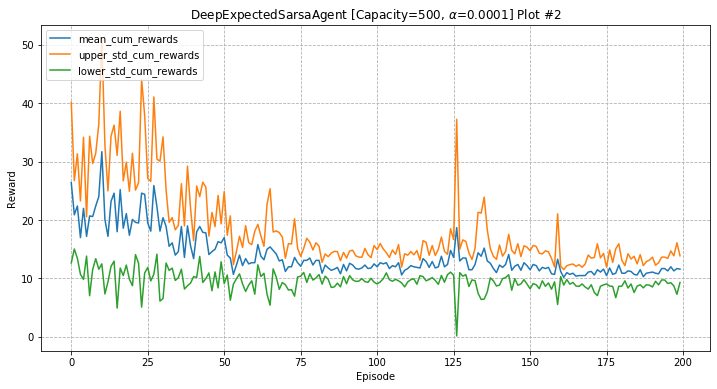

<Figure size 432x288 with 0 Axes>

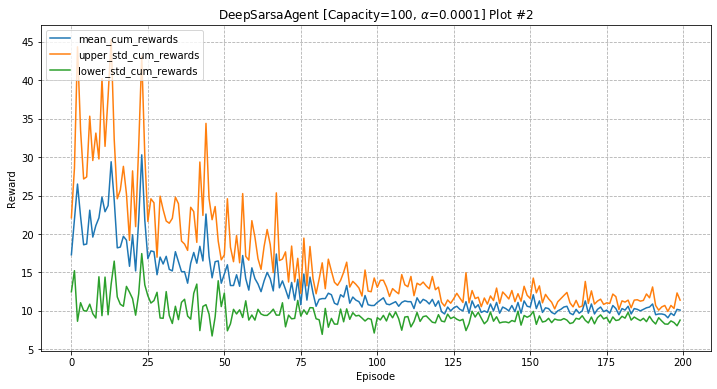

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         2.73417668 2.75554657
 2.73956602 2.74478953 2.67745068 2.55872452 2.55066602 2.51675215
 2.48822682 2.40821671 2.29450938 2.13547404 1.97649449 1.86519432
 1.88889127 1.80254707 1.65314486 1.68986802 1.57804602 1.53731931
 1.69365348 1.82836523 1.68929347 1.76988485 1.90620722 1.74104481
 1.7122259  1.79185876 1.86397405 1.87004241 1.74309072 1.83963039
 1.92362245 1.91180702 2.00158563 2.13874062 2.14527128 2.19073226
 2.20753527 2.19404411 2.22346444 2.22098777 2.20431851 2.05161886
 1.98491378 1.97876585 1.95335375 1.98252491 1.94321823 1.95276079
 1.86976004 1.85997326 1.84302753 1.73754088 1.78215762 1.74753501
 1.72593715 1.60116889 1.59091699 1.62563624 1.67573611 1.75748237
 1.75079433 1.7947518  1.71815279 1.76815784 1.6998969  1.80627774
 1.83193545 1.66275

<Figure size 432x288 with 0 Axes>

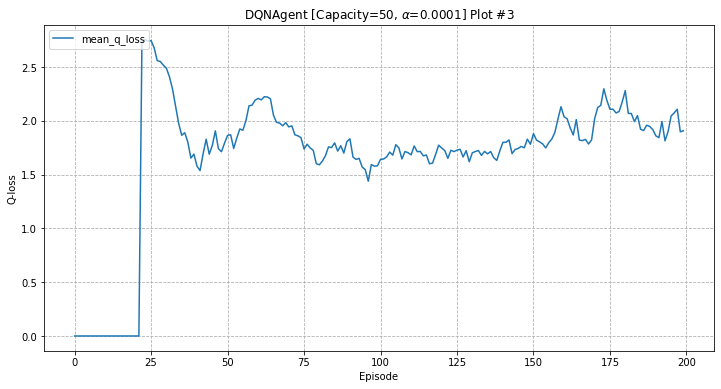

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         2.55258505
 2.50460353 2.4610055  2.43195267 2.45491023 2.35791622 2.28435738
 2.3087532  2.1353875  2.08116329 1.8685733  1.78880666 1.67450237
 1.54617358 1.34133056 1.426789   1.54540051 1.52368689 1.41332814
 1.47433605 1.59686004 1.58584559 1.56830599 1.53909447 1.52597945
 1.37061994 1.48904924 1.5840137  1.51129332 1.56493179 1.71221087
 1.59583175 1.64159359 1.56591586 1.64858083 1.76817372 1.76075495
 1.59120209 1.70785636 1.7000104  1.57304988 1.5675488  1.52056428
 1.46478688 1.45501139 1.42093986 1.39861423 1.42825374 1.41859769
 1.36904885 1.31488982 1.29982212 1.30652556 1.33584577 1.35646014
 1.28593231 1.35486552 1.29455588 1.35558872 1.28463814 1.3619901
 1.33207829 1.31474574 1.32383943 1.3051558  1.32396501 1.27190095
 1.25542278 1.368796

<Figure size 432x288 with 0 Axes>

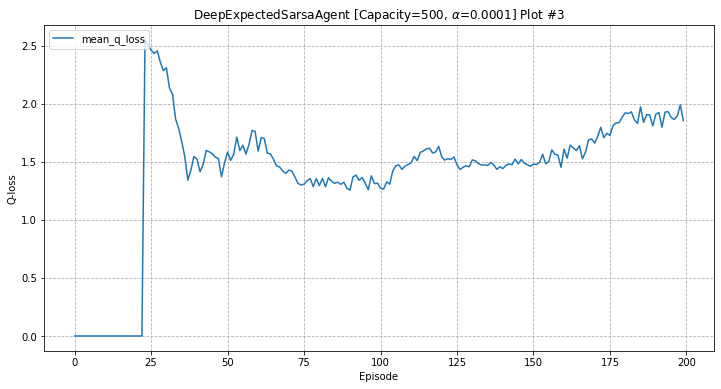

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         2.68037009 2.75149071 2.74308836
 2.68765025 2.65790811 2.62382517 2.59361627 2.46772511 2.4304558
 2.3784133  2.29307587 2.14685597 2.06811051 1.95518699 1.77837672
 1.67973287 1.5405852  1.60845197 1.67118434 1.53698405 1.54620841
 1.56202012 1.5952046  1.70315944 1.7711279  1.89739864 1.89305395
 1.90198083 1.92149932 1.83234938 1.72665733 1.66151134 1.79863271
 1.88548983 1.94883251 1.98377929 2.08381069 2.07829701 2.01873717
 1.95895836 1.93904283 1.84390562 1.89549264 1.88097192 1.9095403
 1.88507736 1.80881065 1.73621539 1.68281024 1.58907051 1.5337322
 1.55436283 1.513555   1.4814374  1.52662697 1.49891703 1.56570125
 1.48703547 1.50975239 1.49206096 1.53991197 1.54274424 1.56181622
 1.59647961 1.64292767 1.62584691 1.57996331 1.61680545 1.56570184
 1.48913535 1.54168544

<Figure size 432x288 with 0 Axes>

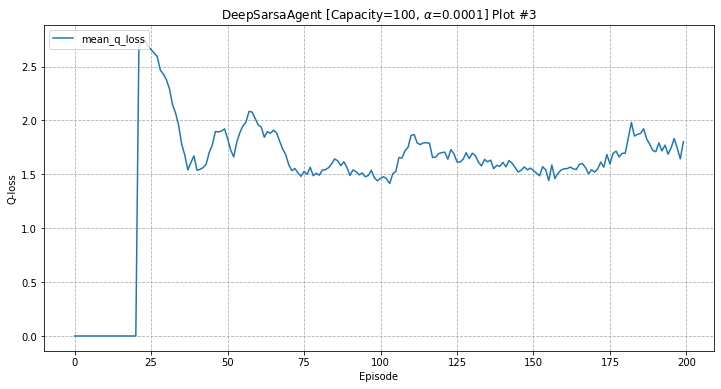

<Figure size 432x288 with 0 Axes>

In [34]:
import pickle
import json
from _jsonnet import evaluate_file
from collections import defaultdict
from typing import Dict
import numpy as np
import matplotlib.pyplot as plt


def nested_d():
    """for any arbitrary number of levels"""
    return defaultdict(nested_d)


def plot_lr_reward(output: Dict):
    cum_reward = -1.0
    best_cap_lr = defaultdict(nested_d)
    for env_name in output.keys():
        for agent, capacities in output[env_name].items():

            plt.rcParams.update({'font.size': 10})
            fig = plt.figure(figsize=(8, 6)).add_subplot(111)
            fig.title.set_text(f'{agent} Plot #1')
            fig.set_ylabel('Average Reward of last 10 episodes')
            fig.set_xlabel(r'$\alpha$')

            for capacity, metrics in capacities.items():
                for metric, lrs in metrics.items():
                    if metric == 'mean_cum_rewards':
                        fig.plot(list(lrs.keys()),
                                 [np.mean(v[-10:]) for k, v in lrs.items()],
                                 label=f'capacity={capacity}', marker='*')
                        for lr, values in lrs.items():
                            best_cap_lr[agent][f'{capacity}_{lr}'] = np.mean(values)
            plt.grid(linestyle='--')
            plt.legend(loc='upper left')
            plt.savefig(f'{agent}_plot_1.png')
            plt.show()
            plt.clf()

    # find max based on...?
    cap_lr = defaultdict(nested_d)
    for agent in output[env_name].keys():
        max_combo = sorted(best_cap_lr[agent].items(), key=lambda x:x[1])
        cap_lr[agent] = [int(max_combo[0][0].split('_')[0]), float(max_combo[0][0].split('_')[1])]
    print(cap_lr)
    # pick a capacity/lr with best episode rewards..
    for env_name in output.keys():
        for agent, capacities in output[env_name].items():
            plt.rcParams.update({'font.size': 10})
            fig = plt.figure(figsize=(12, 6)).add_subplot(111)
            alpha = r'$\alpha$'
            fig.title.set_text(f'{agent} [Capacity={cap_lr[agent][0]}, {alpha}={cap_lr[agent][1]}] Plot #2')
            fig.set_ylabel('Reward')
            fig.set_xlabel('Episode')
            for capacity, metrics in capacities.items():
                if capacity == cap_lr[agent][0]:
                    for metric, lrs in metrics.items():
                        if 'mean' in metric or 'upper' in metric or 'lower' in metric:
                            if 'loss' not in metric and 'timesteps' not in metric:
                                fig.plot(np.arange(len(lrs[cap_lr[agent][1]])),
                                        lrs[cap_lr[agent][1]],
                                        label=metric)
            plt.grid(linestyle='--')
            plt.legend(loc='upper left')
            plt.savefig(f'{agent}_plot_2.png')
            plt.show()
            plt.clf()
    
    for env_name in output.keys():
        for agent, capacities in output[env_name].items():
            plt.rcParams.update({'font.size': 10})
            fig = plt.figure(figsize=(12, 6)).add_subplot(111)
            alpha = r'$\alpha$'
            fig.title.set_text(f'{agent} [Capacity={cap_lr[agent][0]}, {alpha}={cap_lr[agent][1]}] Plot #3')
            fig.set_ylabel('Q-loss')
            fig.set_xlabel('Episode')
            for capacity, metrics in capacities.items():
                if capacity == cap_lr[agent][0]:
                    for metric, lrs in metrics.items():
                        if 'loss' in metric:
                            print(np.nan_to_num(lrs[cap_lr[agent][1]][0]))
                            fig.plot(np.arange(len(lrs[cap_lr[agent][1]][0])),
                                    np.nan_to_num(lrs[cap_lr[agent][1]][0]),
                                    label=metric)
            plt.grid(linestyle='--')
            plt.legend(loc='upper left')
            plt.savefig(f'{agent}_plot_3.png')
            plt.show()
            plt.clf()

# load initial configs for params
cfg = evaluate_file(f'n_step_td_config.jsonnet')
cfg = json.loads(cfg)
ROOT_DIR = '/content/drive/My Drive/Colab Notebooks'
RESULT_DIR = f'{ROOT_DIR}'
experiment_path = f"{RESULT_DIR}/{cfg['experiment_name']}_experiments.pickle"
with open(experiment_path, 'rb') as file:
    output = pickle.load(file)

# specs for the experiment
experiment_cfg = cfg['experiment_cfg']
plot_lr_reward(output)

In [0]:
from google.colab import files
import glob
results = glob.glob('*.png')
for file in results:
    files.download(file)

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!pip install jsonnet

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 256kB 2.8MB/s 
  Created wheel for jsonnet: filename=jsonnet-0.15.0-cp36-cp36m-linux_x86_64.whl size=3320567 sha256=b1ac73d0e3b6f8ee0afcabce6696d3ac350c2717a91767be6ee52013d9c56a50
  Stored in directory: /root/.cache/pip/wheels/57/63/2e/da89cfe1ba08550bd7262d5d9c027edc313980c3b85b3b0a38
Successfully built jsonnet
